In [1]:
import pandas as pd
import numpy as np
import sys
import pickle
import glob
import os
import sqlite3
import matplotlib.pyplot as plt

In [2]:
from sklearn import neighbors

In [3]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

In [4]:
# EXPERIMENT_DIR = '/home/ubuntu/experiments/dwm-test'
EXPERIMENT_DIR = '/Users/darylwilding-mcbride/Downloads/experiments/dwm-test'

In [5]:
EXTRACTED_FEATURES_DB_NAME = "{}/extracted-features/extracted-features.sqlite".format(EXPERIMENT_DIR)
MAPPING_FILE_NAME = "{}/recalibrated-percolator-output/percolator-idx-mapping.csv".format(EXPERIMENT_DIR)


In [6]:
# determine the mapping between the percolator index and the run file name
def get_percolator_run_mapping(mapping_file_name):
    df = pd.read_csv(mapping_file_name)
    mapping_l = [tuple(r) for r in df.to_numpy()]
    return mapping_l

def file_idx_for_run(run_name):
    result = None
    mapping_l = get_percolator_run_mapping(MAPPING_FILE_NAME)
    for m in mapping_l:
        if m[1] == run_name:
            result = m[0]
            break
    return result

def run_name_for_file_idx(file_idx):
    result = None
    mapping_l = get_percolator_run_mapping(MAPPING_FILE_NAME)
    for m in mapping_l:
        if m[0] == file_idx:
            result = m[1]
            break
    return result


#### plot the normalised intensity to compare the 1to1 and 1to3

In [7]:
df = pd.read_csv('/Users/darylwilding-mcbride/Downloads/experiments/dwm-test/extracted-features/extracted-features.csv')

In [8]:
df['intensity_log'] = np.log2(df.intensity)

In [9]:
# find the experiment-wide intensity median for each sequence
experiment_means_l = []
for group_name,group_df in df.groupby(['sequence','charge'], as_index=False):
    # intensity
    experiment_intensity_log_mean = np.mean(group_df.intensity_log)
    experiment_intensity_mean = np.mean(group_df.intensity)

    experiment_intensity_log_median = np.median(group_df.intensity_log)
    experiment_intensity_median = np.median(group_df.intensity)

    # sequence and charge
    sequence = group_name[0]
    charge = group_name[1]
    experiment_means_l.append((sequence,charge,experiment_intensity_mean,experiment_intensity_log_mean,experiment_intensity_median,experiment_intensity_log_median))

experiment_means_df = pd.DataFrame(experiment_means_l, columns=['sequence','charge','experiment_intensity_mean','experiment_intensity_log_mean','experiment_intensity_median','experiment_intensity_log_median'])


In [10]:
df = pd.merge(df, experiment_means_df, how='left', left_on=['sequence','charge'], right_on=['sequence','charge'])


In [11]:
df['delta_intensity_log'] = df.intensity_log - df.experiment_intensity_log_median

In [12]:
NUMBER_OF_RUNS = df.number_of_runs_extracted.max()
NUMBER_OF_RUNS

20

In [13]:
MINIMUM_NUMBER_OF_RUNS = int(NUMBER_OF_RUNS / 2)
NUMBER_OF_1TO1_RUNS = 10
NUMBER_OF_1TO3_RUNS = 10

#### before normalisation

In [14]:
# for each sequence and charge, if it was found in more than 5 of the 1to1 and 5 of the 1to3 runs, 
# find the mean intensity in each batch, then find the intensity ratio between batches
sequence_occurences_in_batch = []
for group_name,group_df in df.groupby(['sequence','charge'], as_index=False):
    sequence_in_1to1_df = group_df[group_df.batch == '1to1']
    sequence_in_1to3_df = group_df[group_df.batch == '1to3']
    if (len(sequence_in_1to1_df) >= int(NUMBER_OF_1TO1_RUNS / 2)) and (len(sequence_in_1to3_df) >= int(NUMBER_OF_1TO3_RUNS / 2)):
        average_intensity_in_1to1 = sequence_in_1to1_df.intensity.mean()
        average_intensity_in_1to3 = sequence_in_1to3_df.intensity.mean()
        human = group_df.iloc[0].human
        sequence = group_name[0]
        charge = group_name[1]
        sequence_occurences_in_batch.append((sequence, charge, average_intensity_in_1to1, average_intensity_in_1to3, human))

In [15]:
sequence_occurences_in_batch_df = pd.DataFrame(sequence_occurences_in_batch, columns=['sequence','charge','intensity_1to1','intensity_1to3','human'])

In [16]:
sequence_occurences_in_batch_df['intensity_ratio'] = sequence_occurences_in_batch_df.intensity_1to3 / sequence_occurences_in_batch_df.intensity_1to1

In [17]:
human_df = sequence_occurences_in_batch_df[sequence_occurences_in_batch_df.human == True]
ecoli_df = sequence_occurences_in_batch_df[sequence_occurences_in_batch_df.human == False]

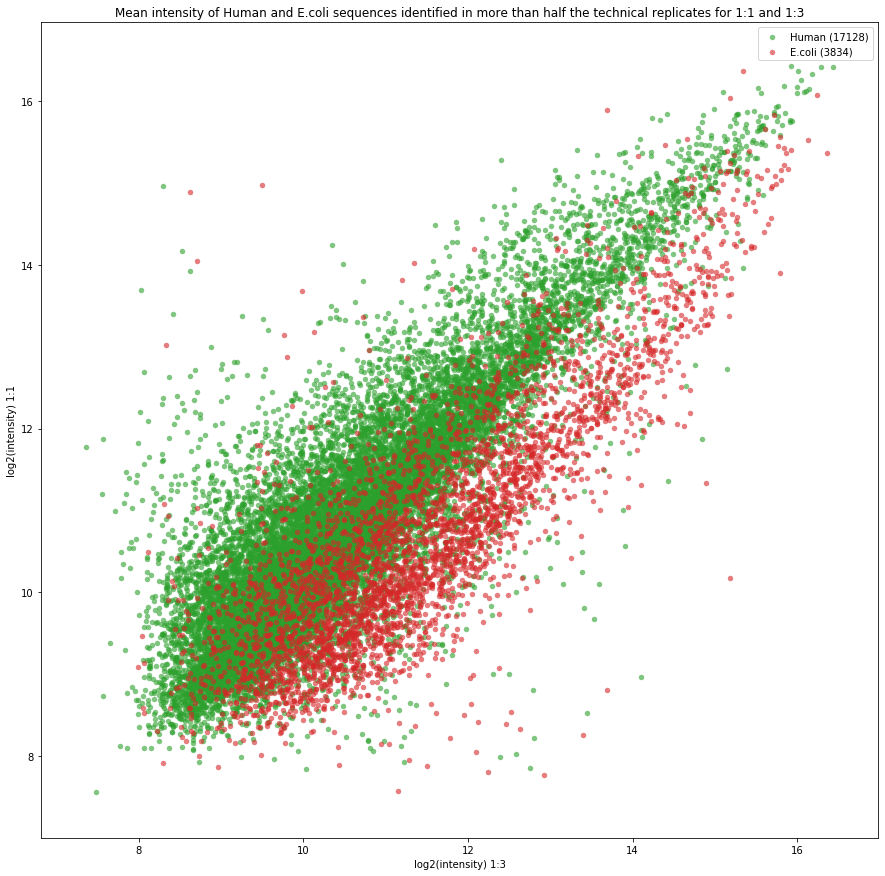

In [18]:
# For each sequence-charge identified in more than 5 runs in 1to1 and more than 5 runs in 1to3, take the average intensity in 
# each batch and plot their intensity. We should expect to see a shift in the E.coli sequences because they are 3 
# times more concentrated in the 1:3 batch.
f, ax = plt.subplots()
f.set_figheight(15)
f.set_figwidth(15)
plt.margins(0.06)

title = 'Mean intensity of Human and E.coli sequences identified in more than half the technical replicates for 1:1 and 1:3'
plt.title(title)

ax.scatter(np.log2(human_df.intensity_1to3), np.log2(human_df.intensity_1to1), marker='o', color='tab:green', lw=0, s=30, alpha=0.6, label="Human ({})".format(len(human_df)))
ax.scatter(np.log2(ecoli_df.intensity_1to3), np.log2(ecoli_df.intensity_1to1), marker='o', color='tab:red', lw=0, s=30, alpha=0.6, label="E.coli ({})".format(len(ecoli_df)))

plt.legend(loc='best')
plt.xlabel('log2(intensity) 1:3')
plt.ylabel('log2(intensity) 1:1')

# plt.xlim((4,17))
# plt.ylim((4,17))

plt.show()

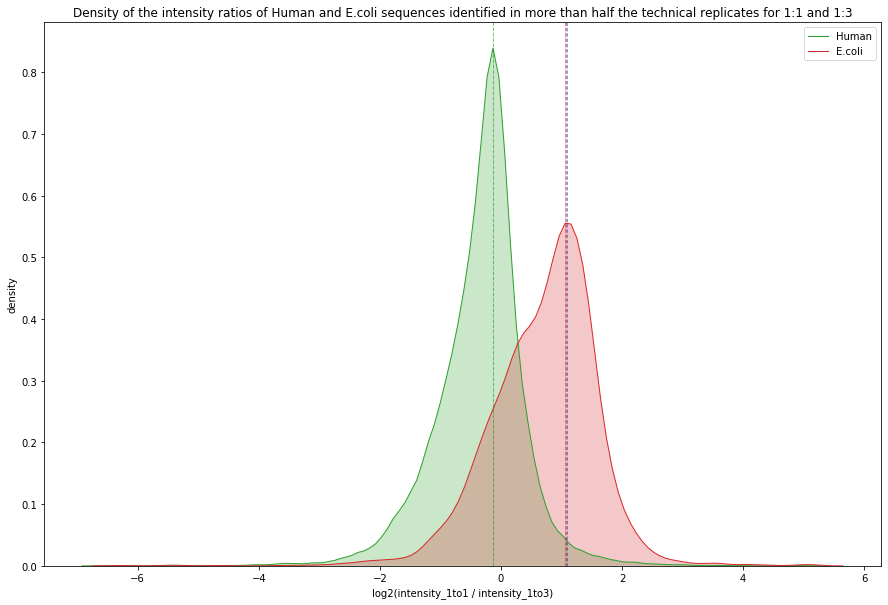

In [19]:
import seaborn as sns
plt.figure(figsize=(15, 10))

title = 'Density of the intensity ratios of Human and E.coli sequences identified in more than half the technical replicates for 1:1 and 1:3'
plt.title(title)

# plt.xlim((-4,4))
# plt.ylim((0,1))

ax = sns.distplot(np.log2(human_df['intensity_ratio']), hist = False, color='tab:green', kde = True, kde_kws = {'shade': True, 'linewidth': 1}, label = 'Human')
_ = sns.distplot(np.log2(ecoli_df['intensity_ratio']), hist = False, color='tab:red', kde = True, kde_kws = {'shade': True, 'linewidth': 1}, label = 'E.coli')

x = ax.lines[0].get_xdata()
y = ax.lines[0].get_ydata()
plt.axvline(x[np.argmax(y)], color='green', lw=0.5, ls='-.')

x = ax.lines[1].get_xdata()
y = ax.lines[1].get_ydata()
plt.axvline(x[np.argmax(y)], color='red', lw=0.5, ls='-.')

plt.axvline(np.log(3), color='darkblue', lw=2, ls=':', dash_capstyle='round', alpha=0.4)

_ = ax.set(xlabel='log2(intensity_1to1 / intensity_1to3)', ylabel='density')

#### normalise intensity

In [20]:
training_attributes = ['monoisotopic_mz_centroid','rt_apex','scan_apex']

In [21]:
number_of_neighbours = 10

run_df_l = []
for file_idx in df.file_idx.unique():
    # get the training set for this run
    sequences_selected_run_df = df[df.file_idx == file_idx].copy()
    training_set_selected_run_df = sequences_selected_run_df[(sequences_selected_run_df.human == True) & (sequences_selected_run_df.number_of_runs_extracted >= MINIMUM_NUMBER_OF_RUNS)]
    sample_size = int(0.6 * len(training_set_selected_run_df))
    training_set_selected_run_df = training_set_selected_run_df.sample(n=sample_size)

    X_train = training_set_selected_run_df[training_attributes].values
    y_train = training_set_selected_run_df[['delta_intensity_log']].values[:,0]

    # fit the model
    knn = neighbors.KNeighborsRegressor(n_neighbors=number_of_neighbours, algorithm='kd_tree', weights='distance')
    _ = knn.fit(X_train, y_train)

    X = sequences_selected_run_df[training_attributes].values

    # estimate the delta intensity
    sequences_selected_run_df['predicted_delta_intensity_log'] = knn.predict(X)
    sequences_selected_run_df['normalised_intensity_log'] = sequences_selected_run_df.intensity_log - sequences_selected_run_df.predicted_delta_intensity_log
    sequences_selected_run_df['normalised_intensity'] = np.power(2, sequences_selected_run_df.normalised_intensity_log)
    run_df_l.append(sequences_selected_run_df)

normalised_experiment_df = pd.concat(run_df_l, axis=0, sort=False)


In [22]:
normalised_experiment_df[['sequence','charge','intensity','experiment_intensity_median','delta_intensity_log','predicted_delta_intensity_log','normalised_intensity']].sample(5)


,sequence,charge,intensity,experiment_intensity_median,delta_intensity_log,predicted_delta_intensity_log,normalised_intensity
63623,VGACTLVAADSETVDR,2,33332,41989.5,-0.331121,-0.386272,43565.297260
122385,KVEEEDEEEEEEEEEEEEEEDE,2,853,1072.0,-0.327645,-0.327645,1070.483536
436199,EPLPSLEAVYLITPSEK,2,789,533.0,0.567608,0.567608,532.365476
86806,VLTEDEMGHPEIGDAIAR,3,1244,1719.0,-0.434415,-0.434415,1681.094881
157360,YSSNIALMCGSGCAGAHK,2,1223,2158.0,-0.763624,0.135146,1113.636461


#### after normalisation

In [23]:
# for each sequence and charge, if it was found in more than 5 of the 1to1 and 5 of the 1to3 runs, 
# find the mean intensity in each batch, then find the intensity ratio between batches
sequence_occurences_in_batch = []
for group_name,group_df in normalised_experiment_df.groupby(['sequence','charge'], as_index=False):
    sequence_in_1to1_df = group_df[group_df.batch == '1to1']
    sequence_in_1to3_df = group_df[group_df.batch == '1to3']
    if (len(sequence_in_1to1_df) >= int(NUMBER_OF_1TO1_RUNS / 2)) and (len(sequence_in_1to3_df) >= int(NUMBER_OF_1TO3_RUNS / 2)):
        average_intensity_in_1to1 = sequence_in_1to1_df.normalised_intensity.mean()
        average_intensity_in_1to3 = sequence_in_1to3_df.normalised_intensity.mean()
        human = group_df.iloc[0].human
        sequence = group_name[0]
        charge = group_name[1]
        sequence_occurences_in_batch.append((sequence, charge, average_intensity_in_1to1, average_intensity_in_1to3, human))

In [24]:
sequence_occurences_in_batch_df = pd.DataFrame(sequence_occurences_in_batch, columns=['sequence','charge','intensity_1to1','intensity_1to3','human'])

In [25]:
sequence_occurences_in_batch_df['intensity_ratio'] = sequence_occurences_in_batch_df.intensity_1to3 / sequence_occurences_in_batch_df.intensity_1to1

In [26]:
human_df = sequence_occurences_in_batch_df[sequence_occurences_in_batch_df.human == True]
ecoli_df = sequence_occurences_in_batch_df[sequence_occurences_in_batch_df.human == False]

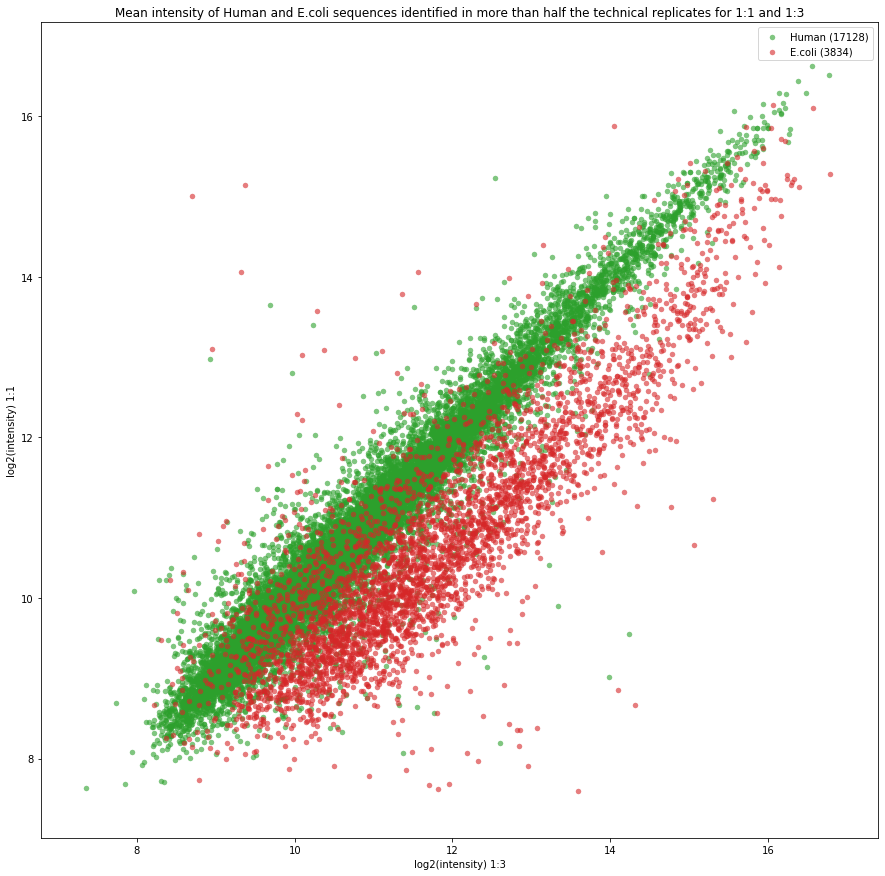

In [27]:
# For each sequence-charge identified in more than 5 runs in 1to1 and more than 5 runs in 1to3, take the average intensity in 
# each batch and plot their intensity. We should expect to see a shift in the E.coli sequences because they are 3 
# times more concentrated in the 1:3 batch.
f, ax = plt.subplots()
f.set_figheight(15)
f.set_figwidth(15)
plt.margins(0.06)

title = 'Mean intensity of Human and E.coli sequences identified in more than half the technical replicates for 1:1 and 1:3'
plt.title(title)

ax.scatter(np.log2(human_df.intensity_1to3), np.log2(human_df.intensity_1to1), marker='o', color='tab:green', lw=0, s=30, alpha=0.6, label="Human ({})".format(len(human_df)))
ax.scatter(np.log2(ecoli_df.intensity_1to3), np.log2(ecoli_df.intensity_1to1), marker='o', color='tab:red', lw=0, s=30, alpha=0.6, label="E.coli ({})".format(len(ecoli_df)))

plt.legend(loc='best')
plt.xlabel('log2(intensity) 1:3')
plt.ylabel('log2(intensity) 1:1')

# plt.xlim((4,17))
# plt.ylim((4,17))

plt.show()

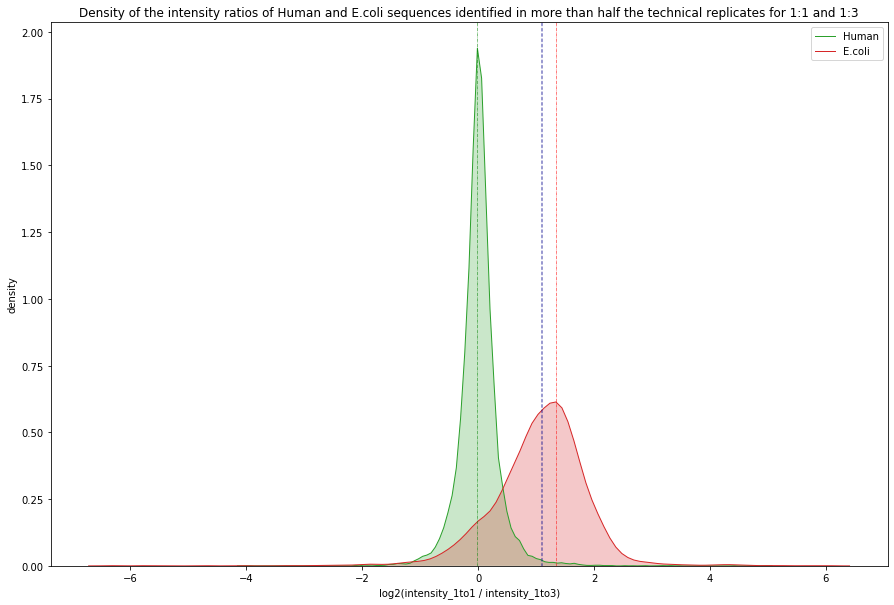

In [28]:
import seaborn as sns
plt.figure(figsize=(15, 10))

title = 'Density of the intensity ratios of Human and E.coli sequences identified in more than half the technical replicates for 1:1 and 1:3'
plt.title(title)

# plt.xlim((-4,4))
# plt.ylim((0,1))

ax = sns.distplot(np.log2(human_df['intensity_ratio']), hist = False, color='tab:green', kde = True, kde_kws = {'shade': True, 'linewidth': 1}, label = 'Human')
_ = sns.distplot(np.log2(ecoli_df['intensity_ratio']), hist = False, color='tab:red', kde = True, kde_kws = {'shade': True, 'linewidth': 1}, label = 'E.coli')

x = ax.lines[0].get_xdata()
y = ax.lines[0].get_ydata()
plt.axvline(x[np.argmax(y)], color='green', lw=0.5, ls='-.')

x = ax.lines[1].get_xdata()
y = ax.lines[1].get_ydata()
plt.axvline(x[np.argmax(y)], color='red', lw=0.5, ls='-.')

plt.axvline(np.log(3), color='darkblue', lw=2, ls=':', dash_capstyle='round', alpha=0.4)

_ = ax.set(xlabel='log2(intensity_1to1 / intensity_1to3)', ylabel='density')

#### 1to1 CV before normalisation

In [29]:
# for each sequence, find the CV
sequence_cv_l = []
for group_name,group_df in normalised_experiment_df[normalised_experiment_df.batch == '1to1'].groupby(['sequence','charge']):
    if len(group_df) == 10:
        intensity_cv = np.std(group_df.intensity) / np.mean(group_df.intensity)
        sequence_cv_l.append((group_name[0], group_name[1], intensity_cv))
sequence_cv_df = pd.DataFrame(sequence_cv_l, columns=['sequence','charge','intensity_cv'])


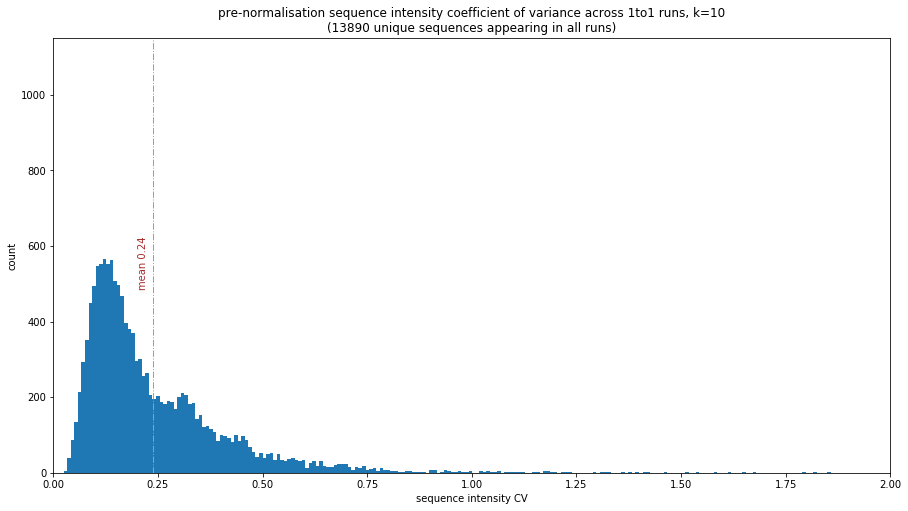

In [44]:
f, ax1 = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

plt.margins(0.06)
plt.title('')

bins = 300
values = sequence_cv_df.intensity_cv
y, x, _ = ax1.hist(values, bins=bins)
mean = np.mean(values)
ax1.axvline(mean, color='darkorange', lw=1.0, ls='-.', label='mean')
text_style = dict(size=10, color='brown', verticalalignment='center', horizontalalignment='left')
ax1.text(mean*0.85, y.max()*0.98, "mean {}".format(round(mean,2)), **text_style, rotation='vertical')

plt.xlabel('sequence intensity CV')
plt.ylabel('count')
plt.title('pre-normalisation sequence intensity coefficient of variance across 1to1 runs, k={}\n({} unique sequences appearing in all runs)'.format(number_of_neighbours, len(sequence_cv_df)))
plt.xlim((0,2))
plt.ylim((0,1150))

plt.show()

#### 1to1 CV after normalisation

In [31]:
# for each sequence, find the CV
normalised_sequence_cv_l = []
for group_name,group_df in normalised_experiment_df[normalised_experiment_df.batch == '1to1'].groupby(['sequence','charge']):
    if len(group_df) == 10:
        intensity_cv = np.std(group_df.normalised_intensity) / np.mean(group_df.normalised_intensity)
        sequence_cv_l.append((group_name[0], group_name[1], intensity_cv))
normalised_sequence_cv_df = pd.DataFrame(sequence_cv_l, columns=['sequence','charge','intensity_cv'])


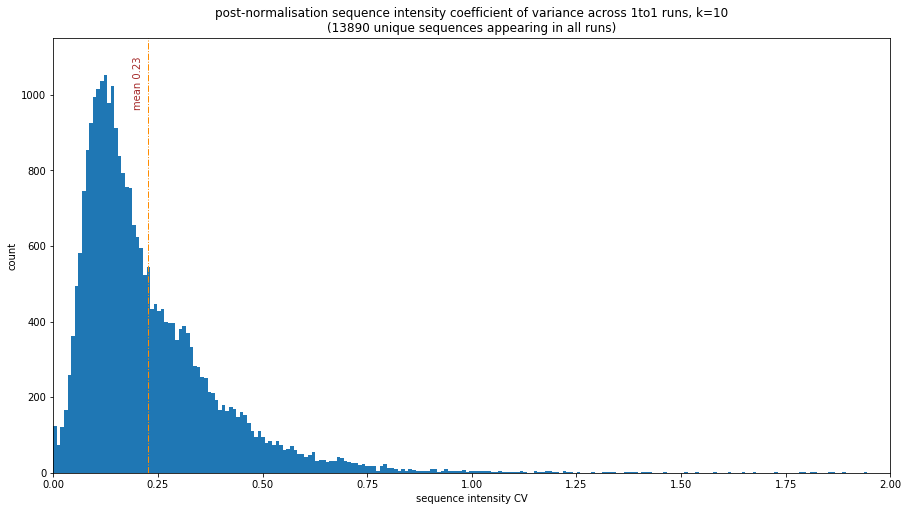

In [43]:
f, ax1 = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

plt.margins(0.06)
plt.title('')

bins = 300
values = normalised_sequence_cv_df.intensity_cv
y, x, _ = ax1.hist(values, bins=bins)
mean = np.mean(values)
ax1.axvline(mean, color='darkorange', lw=1.0, ls='-.', label='mean')
text_style = dict(size=10, color='brown', verticalalignment='center', horizontalalignment='left')
ax1.text(mean*0.85, y.max()*0.98, "mean {}".format(round(mean,2)), **text_style, rotation='vertical')

plt.xlabel('sequence intensity CV')
plt.ylabel('count')
plt.title('post-normalisation sequence intensity coefficient of variance across 1to1 runs, k={}\n({} unique sequences appearing in all runs)'.format(number_of_neighbours, len(sequence_cv_df)))
plt.xlim((0,2))
plt.ylim((0,1150))

plt.show()

#### look at the local adjustment in each dimension for a selected file

In [33]:
run_name = '190719_Hela_Ecoli_1to1_01'
file_idx = file_idx_for_run(run_name)

In [34]:
selected_run_df = normalised_experiment_df[normalised_experiment_df.file_idx == file_idx].copy()

##### intensity delta in the RT dimension

In [46]:
mean_delta_l = []
for group_name,group_df in selected_run_df.groupby(['rt_apex'], as_index=False):
    mean_delta_l.append((group_name, np.mean(group_df.predicted_delta_intensity_log)))
mean_delta_df = pd.DataFrame(mean_delta_l, columns=['rt_apex','mean_predicted_delta_intensity_log'])

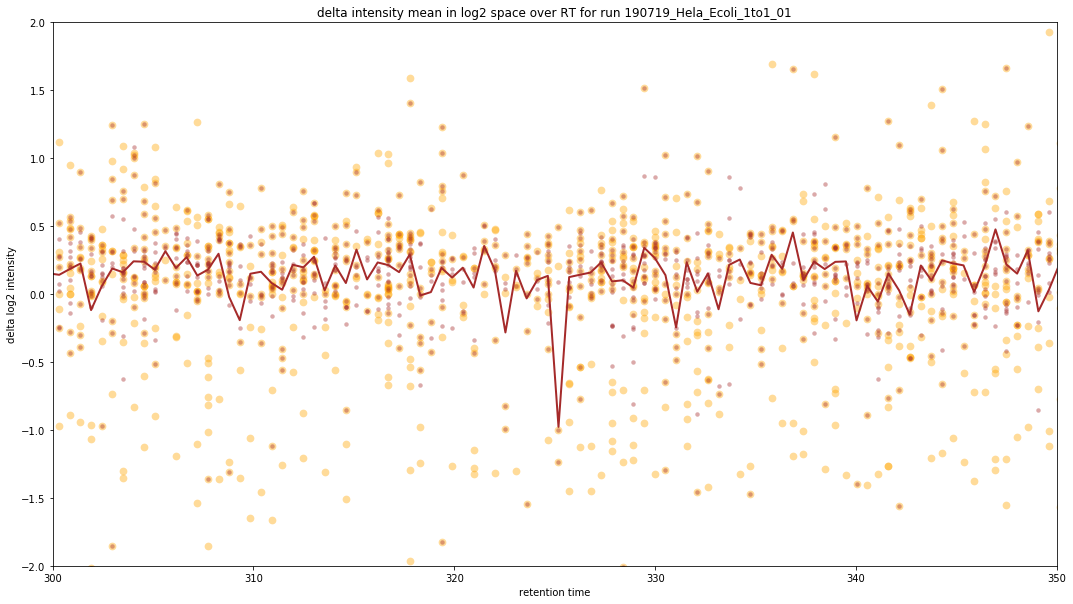

In [47]:
f, ax = plt.subplots()
f.set_figheight(10)
f.set_figwidth(18)

plt.margins(0.06)
plt.title('')

ax.scatter(selected_run_df.rt_apex, selected_run_df.delta_intensity_log, marker='o', color='orange', lw=0, s=60, alpha=0.4)
ax.scatter(selected_run_df.rt_apex, selected_run_df.predicted_delta_intensity_log, marker='o', color='brown', lw=0, s=20, alpha=0.4)
ax.plot(mean_delta_df.rt_apex, mean_delta_df.mean_predicted_delta_intensity_log, marker='', color='brown', linestyle='-', linewidth=2, ms=5)

# plt.legend(loc='best')
plt.ylabel('delta log2 intensity')
plt.xlabel('retention time')
plt.title('delta intensity mean in log2 space over RT for run {}'.format(run_name))
plt.xlim((300,350))
plt.ylim((-2,2))

plt.show()

##### intensity delta in the CCS dimension

In [37]:
mean_delta_l = []
for group_name,group_df in selected_run_df.groupby(['scan_apex'], as_index=False):
    mean_delta_l.append((group_name, np.mean(group_df.predicted_delta_intensity_log)))
mean_delta_df = pd.DataFrame(mean_delta_l, columns=['scan_apex','mean_predicted_delta_intensity_log'])

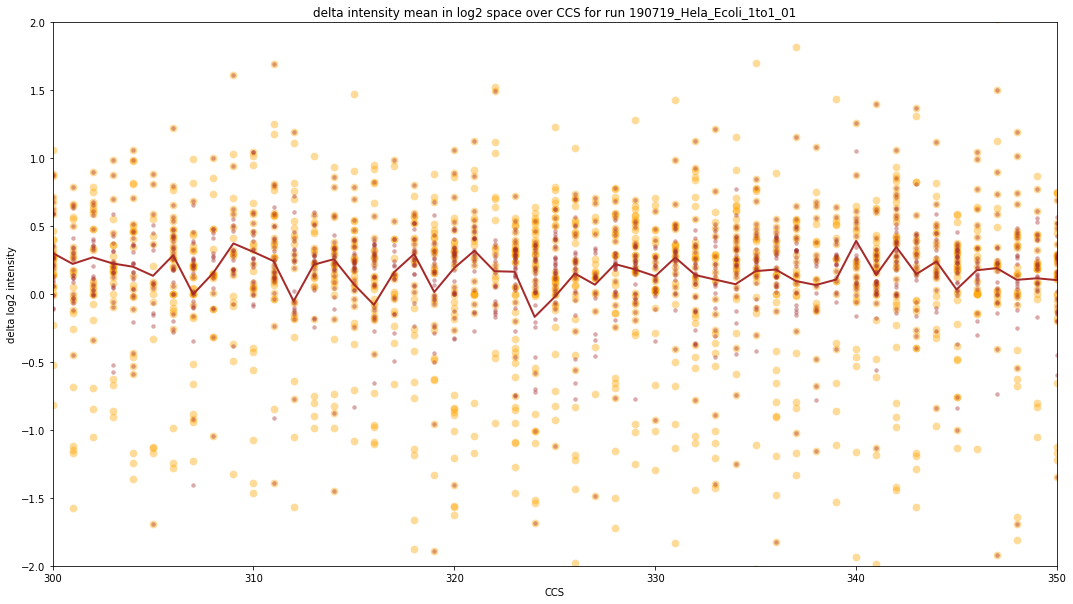

In [38]:
f, ax = plt.subplots()
f.set_figheight(10)
f.set_figwidth(18)

plt.margins(0.06)
plt.title('')

ax.scatter(selected_run_df.scan_apex, selected_run_df.delta_intensity_log, marker='o', color='orange', lw=0, s=60, alpha=0.4)
ax.scatter(selected_run_df.scan_apex, selected_run_df.predicted_delta_intensity_log, marker='o', color='brown', lw=0, s=20, alpha=0.4)
ax.plot(mean_delta_df.scan_apex, mean_delta_df.mean_predicted_delta_intensity_log, marker='', color='brown', linestyle='-', linewidth=2, ms=5)

# plt.legend(loc='best')
plt.ylabel('delta log2 intensity')
plt.xlabel('CCS')
plt.title('delta intensity mean in log2 space over CCS for run {}'.format(run_name))
plt.xlim((300,350))
plt.ylim((-2,2))

plt.show()

##### intensity delta in the m/z dimension

In [48]:
mean_delta_l = []
selected_run_df['mz_truncated'] = selected_run_df.monoisotopic_mz_centroid.astype(int)
for group_name,group_df in selected_run_df.groupby(['mz_truncated'], as_index=False):
    mean_delta_l.append((group_name, np.mean(group_df.predicted_delta_intensity_log)))
mean_delta_df = pd.DataFrame(mean_delta_l, columns=['monoisotopic_mz_centroid','mean_predicted_delta_intensity_log'])

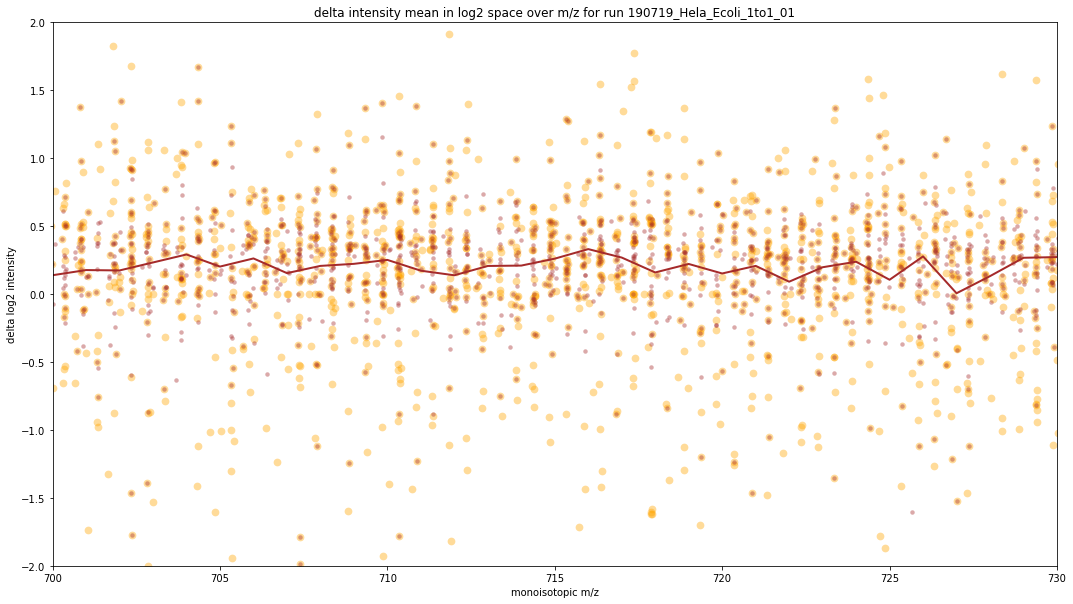

In [49]:
f, ax = plt.subplots()
f.set_figheight(10)
f.set_figwidth(18)

plt.margins(0.06)
plt.title('')

ax.scatter(selected_run_df.monoisotopic_mz_centroid, selected_run_df.delta_intensity_log, marker='o', color='orange', lw=0, s=60, alpha=0.4)
ax.scatter(selected_run_df.monoisotopic_mz_centroid, selected_run_df.predicted_delta_intensity_log, marker='o', color='brown', lw=0, s=20, alpha=0.4)
ax.plot(mean_delta_df.monoisotopic_mz_centroid, mean_delta_df.mean_predicted_delta_intensity_log, marker='', color='brown', linestyle='-', linewidth=2, ms=5)

# plt.legend(loc='best')
plt.ylabel('delta log2 intensity')
plt.xlabel('monoisotopic m/z')
plt.title('delta intensity mean in log2 space over m/z for run {}'.format(run_name))
plt.xlim((700,730))
plt.ylim((-2,2))

plt.show()